# Исследовательский анализ данных

# 1. Постановка задачи

## 1.1 Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.
Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## 1.2 Описание данных

Признаки:

file_name - имя файла
Целевой признак

real_age - возраст

## 1.3 Постановка задачи

Необходимо построить модель с MAE < 8 на валидационной выборке

# 2. Загрузка датасета и библиотек

## 2.1. Импорт библиотек

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

## 2.2. Импорт датасета

In [13]:
def read_data_set(pth1, pth2) -> pd.DataFrame:
    df = pd.DataFrame    
    try:
        df = pd.read_csv(pth1)
    except OSError as e:
        df = pd.read_csv(pth2)
    return df

In [14]:
pth1 = '/datasets/faces/labels.csv'
pth2 = '/datasets/faces/labels.csv'
df = read_data_set(pth1, pth2) 

In [15]:
def read_data_flow(directory:str, dataframe:str):
    
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)   
   
    datagen_flow = datagen.flow_from_dataframe(
    dataframe = dataframe,
    directory = directory,        
    target_size= (150, 150),
    batch_size= 60,
    class_mode='raw',
    subset='training',
    seed=12345,
    x_col='file_name',
    y_col='real_age',
    ) 
        
    return datagen_flow

In [16]:
directory = '/datasets/faces/final_files'
datagen_flow = read_data_flow(directory, df)

Found 5694 validated image filenames.


В ходе данного этапа был загружен и проанализирован датасет с фотографиями людей разного возраста

Дубликаты и пропуски не обнаружены.

## 3. Анализ данных

In [17]:
df.head(10)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


In [18]:
df.info

<bound method DataFrame.info of        file_name  real_age
0     000000.jpg         4
1     000001.jpg        18
2     000002.jpg        80
3     000003.jpg        50
4     000004.jpg        17
...          ...       ...
7586  007608.jpg        14
7587  007609.jpg        37
7588  007610.jpg        28
7589  007611.jpg        20
7590  007612.jpg        47

[7591 rows x 2 columns]>

In [6]:
df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [7]:
df.duplicated().sum()

0

In [8]:
df.isna().sum()

file_name    0
real_age     0
dtype: int64

**Посмотрите на размер выборки:**

In [9]:
print(f'Размер выборки:{df.shape}')

Размер выборки:(7591, 2)


**Постройте график распределения возраста в выборке.**

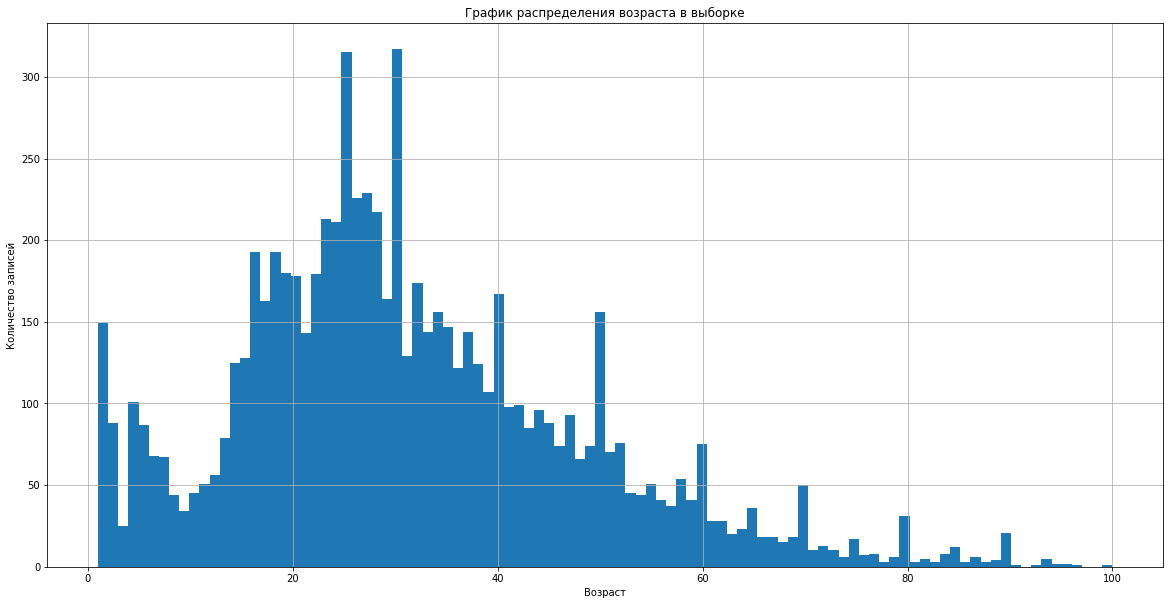

In [10]:
df.real_age.hist(bins=100, figsize=(20,10)) 
plt.title('График распределения возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Количество записей')
plt.show();

**Напечатайте на экране 10–15 фотографий и посмотрите, как устроен датасет.**

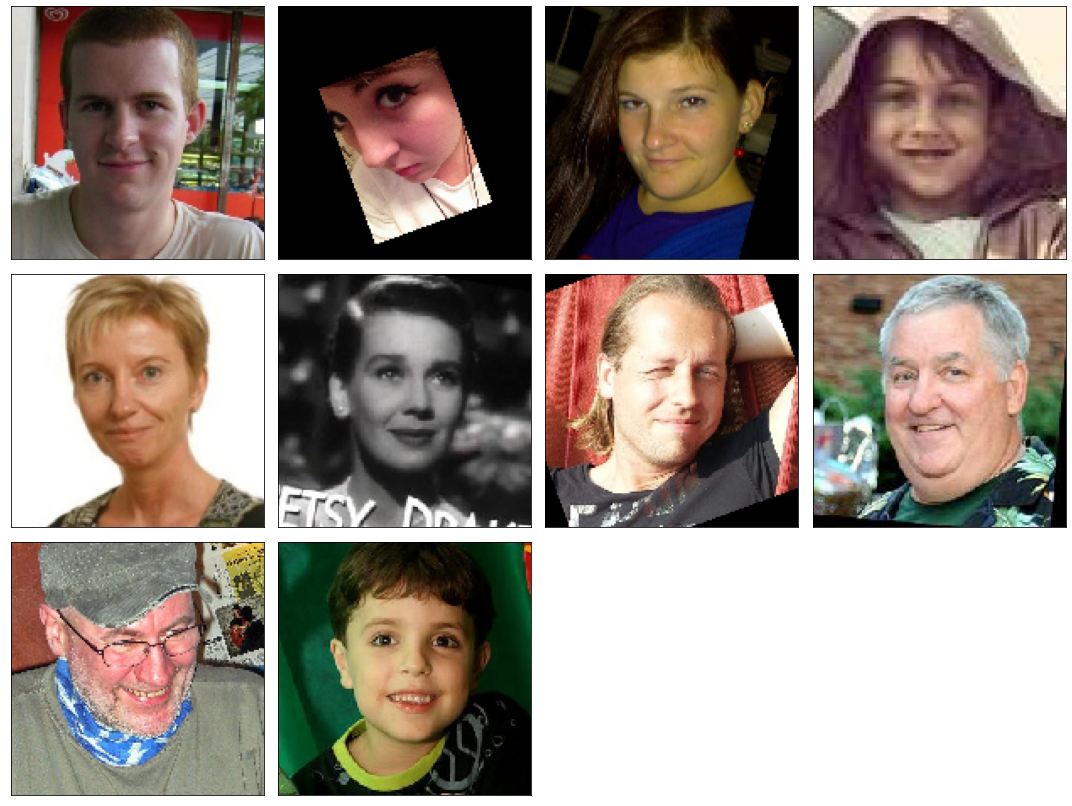

In [11]:
features, target = next(datagen_flow)

fig = plt.figure(figsize=(15,15))
for i in range(10):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
Очень хорошо, что выведены фотографии. Это хорошая практика, помогает увидеть изображения, с которыми будет работать наша модель, заметить какие-то детали и особенности, улучшить понимание задачи и получить определенную интуицию. А также заранее оценить подходящие для наших данных методы аугментации. </div>

**Вывод**:

В ходе данного этапа был выполнен анализ данных

Количество фотографий в датасете: 7591
Минимальный возраст 1  год, максимальный- 100 лет.
Самый "популярный" возраст 20-40 лет

Фотографии явно взяты из открытых источников, а не сделаны в прикассовой зоне. Фотографии имеют разный фон, количество цветов, качество. Какие-то из них обработаны (например как фотографии 2 и 8). Какие-то имеют сторонние надписи (как фотография 6). Часто на фотографиях встречаются разные положения лица. Скорее всего какие-то фотографии будут с закрытыми лицами. Данные особенности датасета существенно осложняют задачу.    

# 4. Построение модели

Ниже приведен код, который был запущен на тренажере

```python
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Conv2D, Flatten, AvgPool2D
from tensorflow.keras.models import Sequential
import pandas as pd

import numpy as np
optimizer = Adam(lr= 0.0001)

def load_train(path):
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255, horizontal_flip=True)     
    dataframe = pd.read_csv(path + 'labels.csv')
    
    train_datagen_flow = datagen.flow_from_dataframe(
    dataframe = dataframe,
    directory = path + 'final_files/',        
    target_size= (224, 224),
    batch_size= 50,
    class_mode='raw',
    subset='training',
    seed=12345,
    x_col='file_name',
    y_col='real_age',
    ) 
   
    return train_datagen_flow

def load_test(path):
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)  
    dataframe = pd.read_csv(path + 'labels.csv')

    val_datagen_flow = datagen.flow_from_dataframe(
    dataframe = dataframe,
    directory = path + 'final_files/',        
    target_size= (224, 224),
    batch_size= 50,
    class_mode='raw',
    subset='validation',
    seed=12345,
    x_col='file_name',
    y_col='real_age',
    ) 
   
    return val_datagen_flow
    
def create_model(input_shape):
    backbone = ResNet50(input_shape= input_shape,
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False) 
    model = Sequential()    
    model.add(backbone) 
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, input_dim = input_shape, activation='relu'))      
    model.compile(loss='mean_absolute_error', 
              optimizer='adam', metrics=['mae'])
    return model    
    
def train_model(model, train_data, test_data, batch_size=None, epochs= 20,
                steps_per_epoch=None, validation_steps=None):
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model
```   

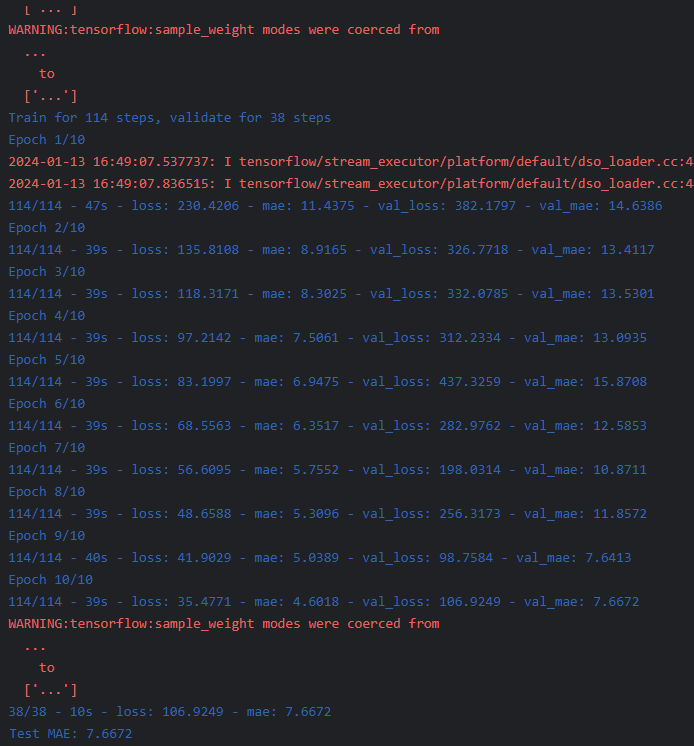

**Вывод**:

В ходе данного этапа была построена модель для определения возраста по фотографии. В качестве модели была применена нейросеть ResNet50 c предварительно расчитанными весами. В качестве метрики была взята MAE. 

На тестовой выборке значение - 4.6  
На валидационной выборке значение - 7.66

**Анализ обучения модели**

В качестве модели была выбрана архитектура ResNet50. Для данного проекта была взята предобученная модель. 
В связи с тем, что метрика MSE дает лучшие результаты, она была использована для обучения модели. Метрика MAE использовалась только для оценки качества. 

В качестве функции активации использовалась ReLu. В качестве оптимизатора был выбран adam c lr= 0.0001. Размер батча - 50. Для улучшения качества модели была применена аугументация (отражения по горизонтали). Добавление других агументаций не давало существенного улучшения целевой метрики.

Удалось достигнуть следующих результатов 

На тестовой выборке значение MAE - 4.6
На валидационной выборке значение MAE - 7.66

В связи с существенной разницей между тестовой и валидационной выборкой можно сделать вывод о том, что модель переобучена

# 5. Общий вывод

## 5.1 Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
Контролировать добросовестность кассиров при продаже алкоголя.
Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## 5.2. Ход выполнения

Работа была выполнена в 3 этапа:

- Загрузка библиотек и датасета
- Исследовательский анализ данных
- Построение модели

В ходе первого этапа был загружен датасет для проведения его анализа. явных дубликатов/пропусков в данных не обнаружено

В ходе второго этапа был проведен анализ данных, а конкретно были даны ответы на вопросы ниже

- Посмотрите на размер выборки
> Количество фотографий в датасете: 7591

- Постройте график распределения возраста в выборке.

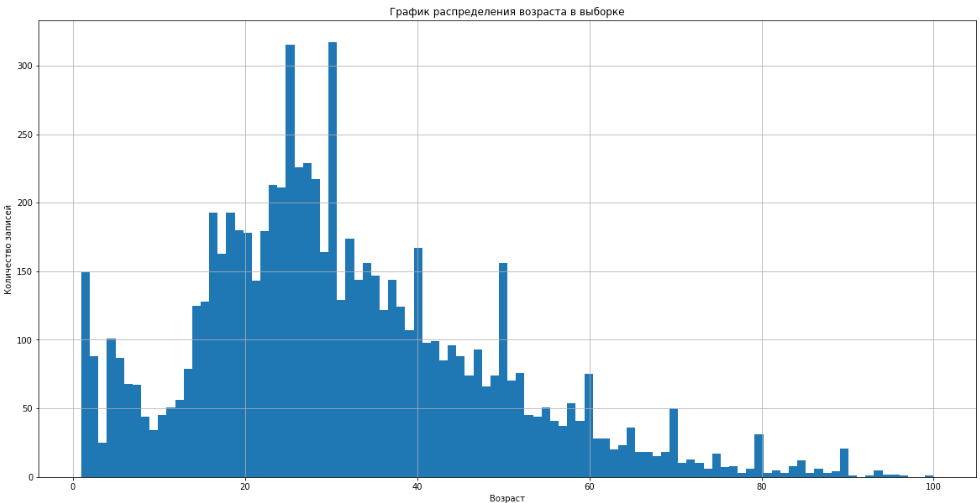

- Напечатайте на экране 10–15 фотографий и посмотрите, как устроен датасет.

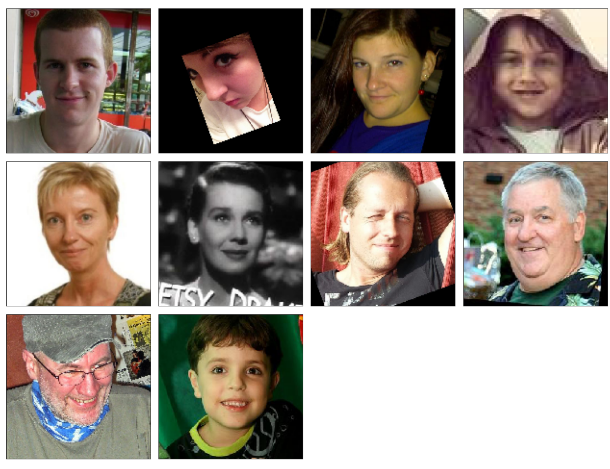

В ходе третьего этапа была построена модель для определения возраста по фотографии. В качестве модели была применена нейросеть ResNet50 c предварительно расчитанными весами. В качестве метрики была взята MAE. 

На тестовой выборке значение - 4.6  
На валидационной выборке значение - 7.66

## 5.3. Общий вывод

В ходе работы был достигнут показатель MAE 7.66 на валидационной выборке, что лучше требуемых 8